In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve1d
import itertools

plt.style.use('ggplot')

   

In [2]:

############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001

# Solve differential equation from time 0 to time T
T = 2

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)




In [3]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# store the solutions
q_all = np.zeros((len(t),freq_bands))
r_all = np.zeros((len(t),freq_bands))




#define the kernels (assuming that they fold over 16 freq_bands)
# x =  np.linspace(0,freq_bands,freq_bands)
# cf = 8



In [4]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.09] = 0.0
    else:
        if r_bpc < 0.09:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.0025] = 0.0
    return np.maximum(q_pc,0)
#     return 1 / (1 + np.exp(-(q_pc-0.5)*8) )
# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel))
            
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    return tau_r * d_r_bpc


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return tau_q * d_q_pc


## Gamma_r influence on LSO response curve

In [13]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 0.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 0.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0



# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

# Parameter to test
gamma_r_all = np.arange(0,2,0.25)

# store values for different parameters
q_all = np.zeros((len(gamma_r_all),len(t),freq_bands))
r_all = np.zeros((len(gamma_r_all),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(0,len(gamma_r_all)):
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            gamma_r = gamma_r_all[k]
            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            







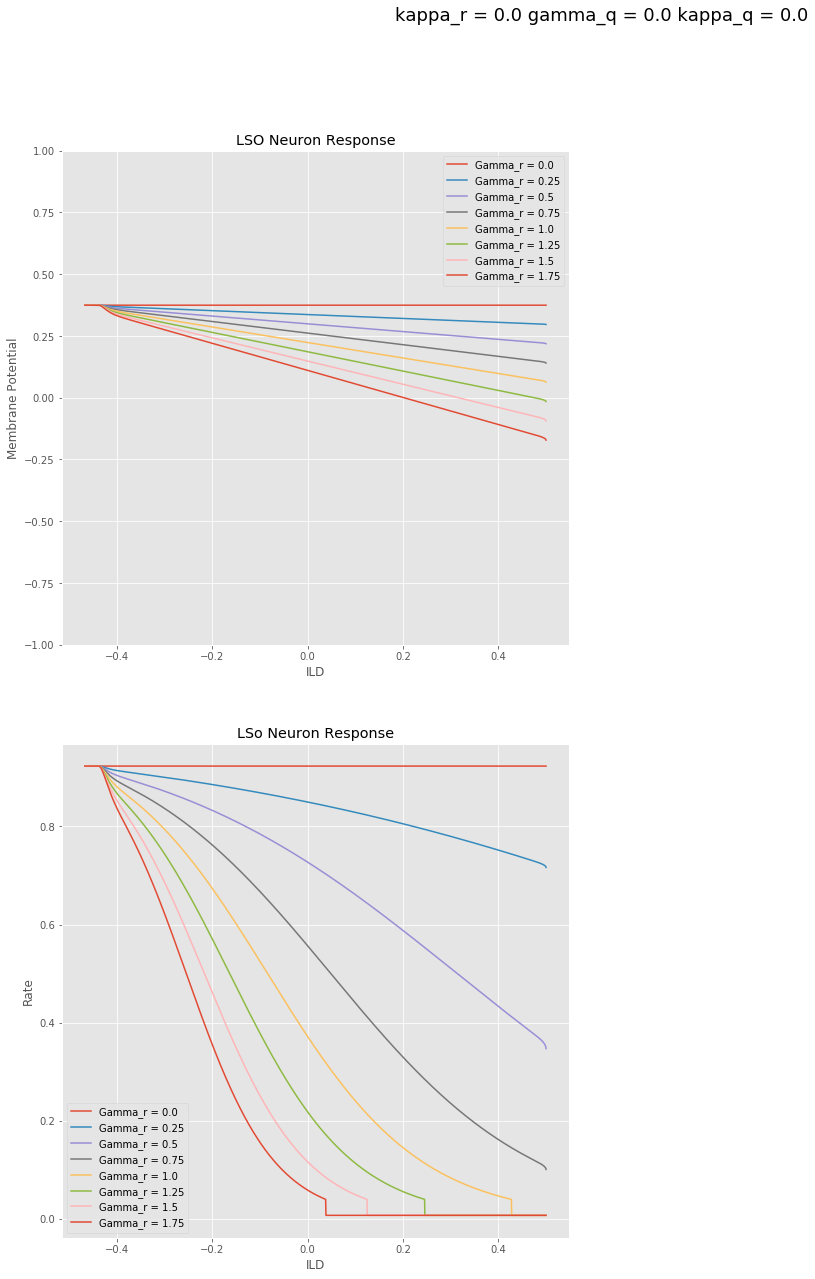

In [14]:
fig = plt.figure(figsize=(20,20))

stri = 'kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=18)

# show LSO neuron membrane
diff_input =  s_gbc_all-s_sbc_all

diff_input = diff_input[250:1750,3]
r = r_all[:,250:1750,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,r[i,:],label='Gamma_r = '+str(gamma_r_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,g_r_out(r[i,:],20,np.mean(r[i,:])),label='Gamma_r = '+str(gamma_r_all[i]))
plt.title('LSo Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()
# plt.ylim([0,1])


plt.show()



## Kappa_r (Divisive) influence on LSO response curve

In [15]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 0.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 0.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0



# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

# Parameter to test
kappa_r_all = np.arange(0,5,1)
kappa_r_all = np.append(kappa_r_all,np.arange(5,30,5))

# store values for different parameters
q_all = np.zeros((len(kappa_r_all),len(t),freq_bands))
r_all = np.zeros((len(kappa_r_all),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(0,len(kappa_r_all)):
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            kappa_r = kappa_r_all[k]
            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            







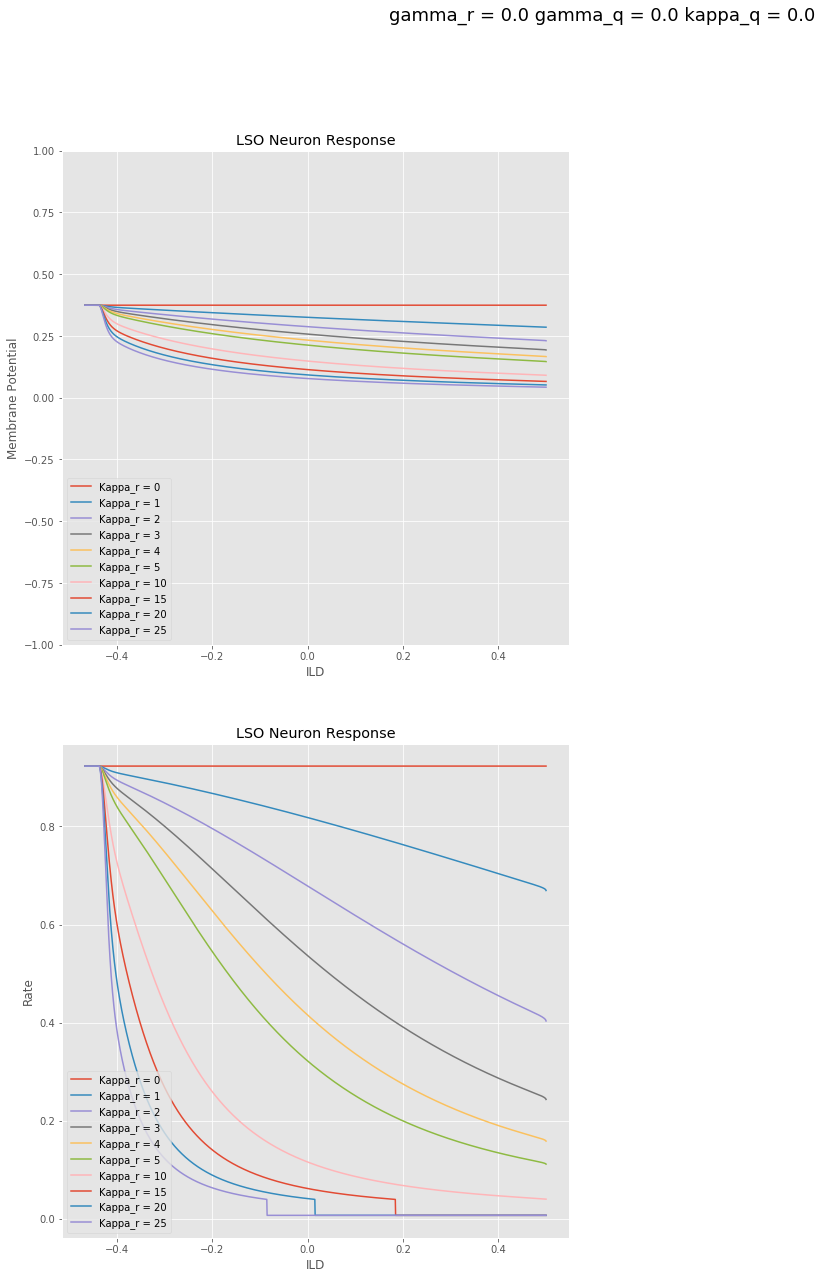

In [16]:
fig = plt.figure(figsize=(20,20))

stri = 'gamma_r = '+str(gamma_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=18)

# show LSO neuron membrane
diff_input =  s_gbc_all-s_sbc_all

diff_input = diff_input[250:1750,3]
r = r_all[:,250:1750,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,r[i,:],label='Kappa_r = '+str(kappa_r_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,g_r_out(r[i,:],60,np.mean(r[i,:])),label='Kappa_r = '+str(kappa_r_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()
# plt.ylim([0,1])


plt.show()



## Gamma_q (Subtractive) influence on LSO response curve

In [9]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0



# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

# Parameter to test
gamma_q_all = np.arange(0,20,5)

# store values for different parameters
q_all = np.zeros((len(gamma_q_all),len(t),freq_bands))
r_all = np.zeros((len(gamma_q_all),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(0,len(gamma_q_all)):
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            kappa_r = gamma_q_all[k]
            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            







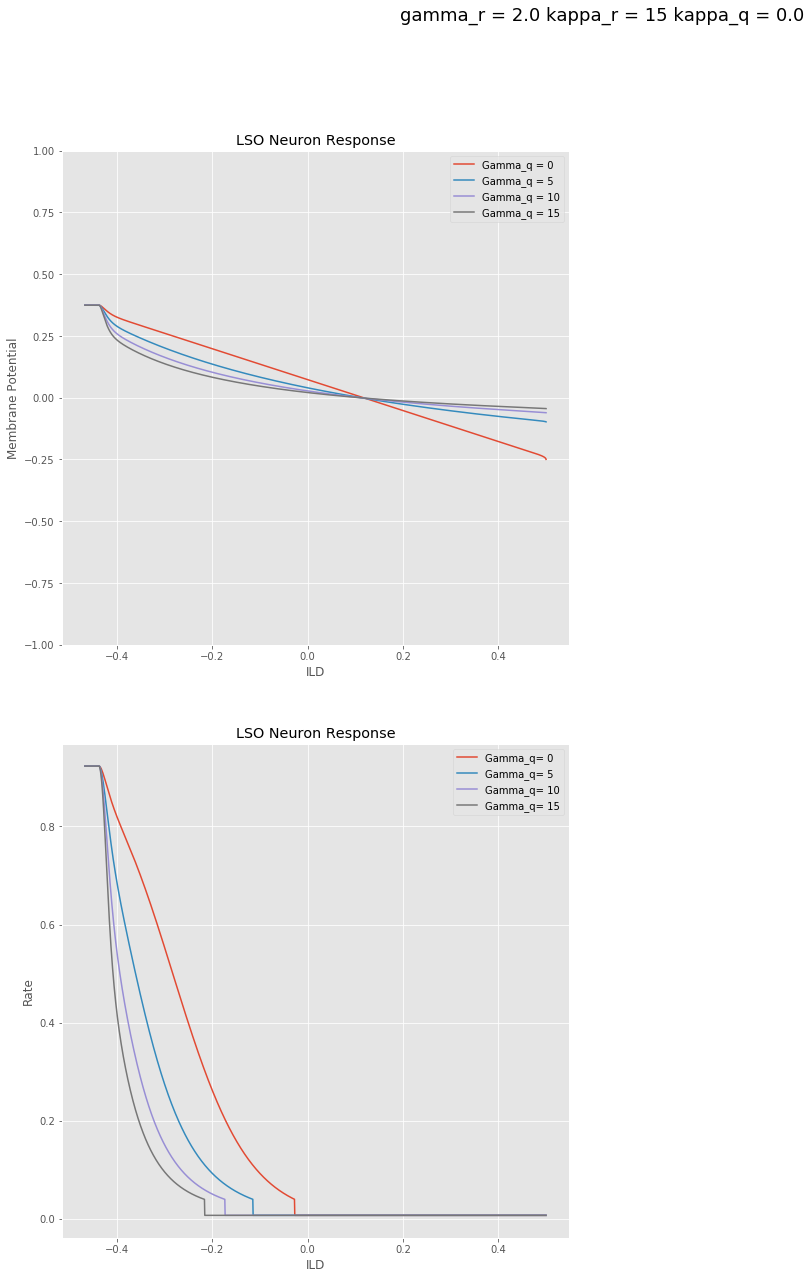

In [10]:
fig = plt.figure(figsize=(20,20))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=18)

# show LSO neuron membrane
diff_input =  s_gbc_all-s_sbc_all

diff_input = diff_input[250:1750,3]
r = r_all[:,250:1750,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,r[i,:],label='Gamma_q = '+str(gamma_q_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,g_r_out(r[i,:],60,np.mean(r[i,:])),label='Gamma_q= '+str(gamma_q_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()
# plt.ylim([0,1])


plt.show()



## Kappa_q(Divisive) influence on LSO response curve

In [11]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand = 3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0



# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

# Parameter to test
kappa_q_all = np.arange(0,20,5)

# store values for different parameters
q_all = np.zeros((len(kappa_q_all),len(t),freq_bands))
r_all = np.zeros((len(kappa_q_all),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(0,len(kappa_q_all)):
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            kappa_r = kappa_q_all[k]
            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            







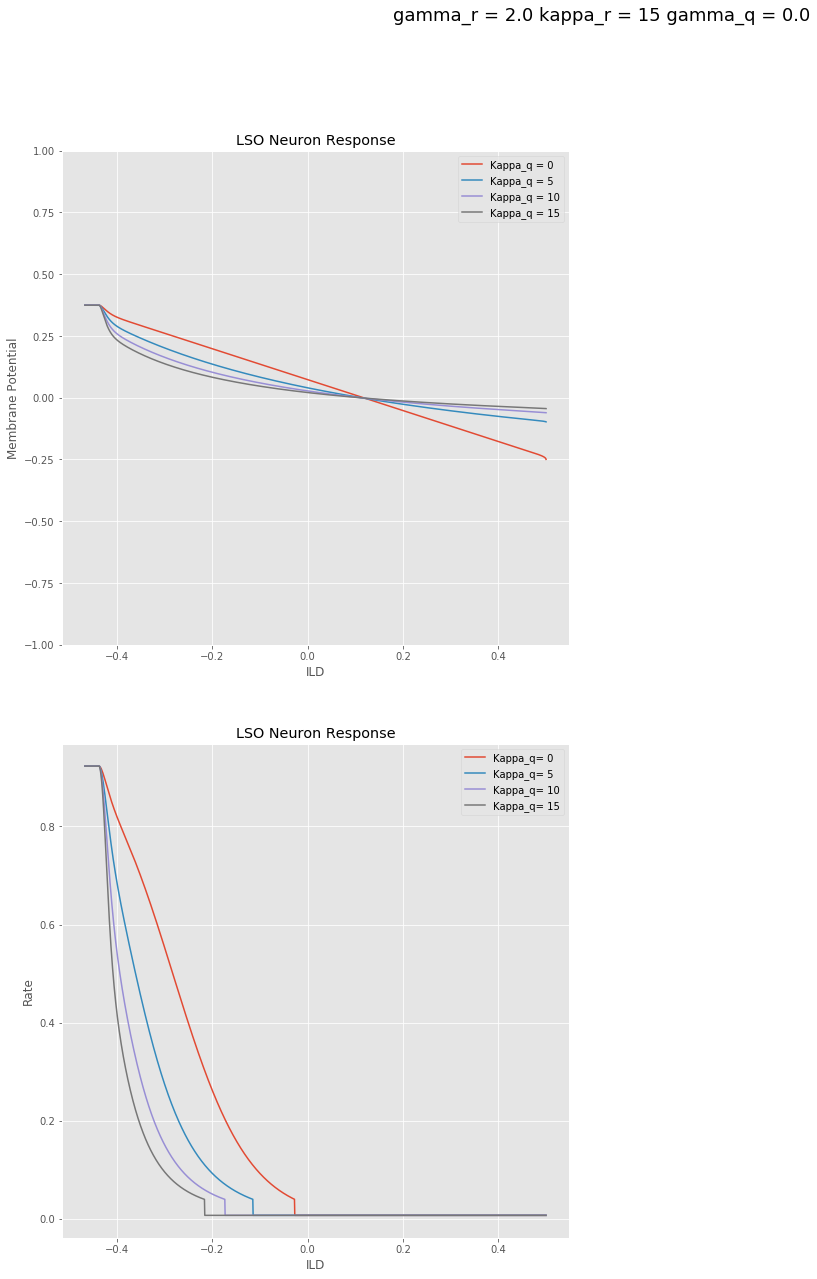

In [12]:
fig = plt.figure(figsize=(20,20))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)
plt.suptitle(stri,fontsize=18)

# show LSO neuron membrane
diff_input =  s_gbc_all-s_sbc_all

diff_input = diff_input[250:1750,3]
r = r_all[:,250:1750,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,r[i,:],label='Kappa_q = '+str(kappa_q_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input,g_r_out(r[i,:],60,np.mean(r[i,:])),label='Kappa_q= '+str(kappa_q_all[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()
# plt.ylim([0,1])


plt.show()

